In [19]:
import gpytorch
import torch
import numpy as np
import matplotlib.pyplot as plt

In [71]:
# We will use the simplest form of GP model, exact inference
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood, training_iter=10, verbose=False):
#         likelihood = gpytorch.likelihoods.GaussianLikelihood()
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module  = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())
        self.reward_observation_times = []
        self.training_iter = training_iter ## Number of epochs hyperparameter retraining
        self.verbose = verbose
        
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

    def add_point(self, x_new, y_new):
        """Implement a finite replay buffer for non stationarity
        If limit buffer reached, delete oldest point
        """
        
        x_train = self.train_inputs[0]
        y_train = self.train_targets
        x_train = torch.cat((x_train, torch.tensor([x_new]).reshape(1,1)))
        y_train = torch.cat((y_train, torch.tensor([y_new])))
            
        self.set_train_data(x_train, y_train, strict=False)
    
    def train_grad(self, training_iter=None):

        #Get model and data
        model, likelihood = self, self.likelihood
        model.train()
        likelihood.train()

        x_train = model.train_inputs[0]
        y_train = model.train_targets

        if training_iter == None:
            training_iter = self.training_iter

        # Find optimal model hyperparameters
        optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters            
        mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

        for i in range(training_iter):
            # Zero gradients from previous iteration
            optimizer.zero_grad()
            # Output from model
            output = model(x_train)
            # Calc loss and backprop gradients

            loss = -mll(output, y_train)
            loss.backward()
            
            if self.verbose:
                print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
                    i + 1, self.training_iter, loss.item(),
                    model.covar_module.base_kernel.lengthscale.item(),
                    model.likelihood.noise.item()
                ))
            
            optimizer.step()
            
    def build_plot(self, ax, lv=None, uv=None, n_test=100, xlabel=None):
        """Build matplotlib graph for one strat

        Args:
            ax (matplotlib.axe): graph to plot on
            lv (int, optional): lower x value. Defaults to -1.
            uv (int, optional): upper x value. Defaults to 1.
            n_test (int, optional): number of test points. Defaults to 100.
            xlabel (String, optional): label for x axis. Defaults to None.

        Returns:
            matplotlib.axe: graph plotted
        """
        
        # Get model and predictions
        model, likelihood = self, self.likelihood
        model.eval()
        likelihood.eval()
        
        if lv is None:
            try:
                lv, uv = model.train_inputs[0].min().item(), model.train_inputs[0].max().item()
            except Exception as e:
                # Here, it's certainly because the train_inputs is empty !! and this method has been called right after a complete reset
                lv, uv = -1, 1
        
        with torch.no_grad(), gpytorch.settings.fast_pred_var():
            test_x = torch.linspace(lv, uv, n_test).double()
            observed_pred = likelihood(model(test_x))
        
        train_x = model.train_inputs[0]
        train_y = model.train_targets

        # Get upper and lower confidence bounds
        lower, upper = observed_pred.confidence_region()
        
        # Plot training data as black stars
        ax.plot(train_x.numpy(), train_y.numpy(), 'k*')

        # Plot predictive means as blue line
        ax.plot(test_x.numpy(), observed_pred.mean.numpy(), 'k', linewidth=3)
        
        # Shade between the lower and upper confidence bounds
        ax.fill_between(test_x.detach().numpy(), lower.detach().numpy(), upper.detach().numpy(), alpha=0.5, 
                          facecolor='silver', hatch="ooo", edgecolor="gray")

        ax.grid(axis='both', color='gainsboro', linestyle='-', linewidth=0.5)

        
        if xlabel:
            ax.set_xlabel(xlabel)
        return ax

In [103]:
real_operator = lambda x: x**2

# initialise a GP
likelihood = gpytorch.likelihoods.GaussianLikelihood() 
GP = ExactGPModel(torch.zeros((0, 1), dtype=torch.float64), 
                  torch.zeros(0, dtype=torch.float64), 
                  likelihood)
GP.eval()

for i in range(10):
    random_x =  4*np.random.random() - 2
    GP.add_point(random_x, real_operator(random_x))
    GP.train_grad()

<AxesSubplot: >

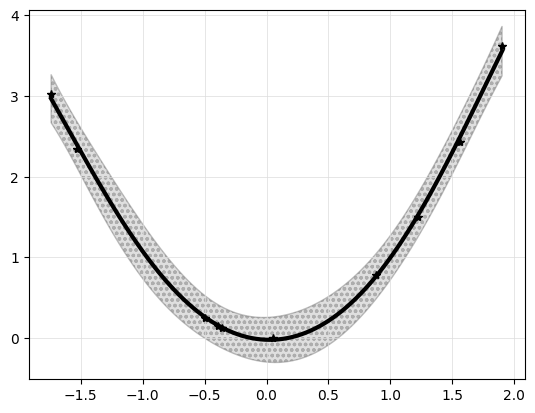

In [104]:
fig, ax = plt.subplots(1, 1)
GP.build_plot(ax)

In [108]:
draws  = {}
n_test = 20
space_draw = torch.linspace(-2, 2, n_test)

for i in range(n_test):
    # sample multiple functions    
    with torch.no_grad(), gpytorch.settings.fast_pred_var():
        observed_pred = GP.likelihood(GP(space_draw))
        with gpytorch.settings.fast_computations(covar_root_decomposition=False):
            the_draw = observed_pred.rsample()
            
    draws[i] = the_draw

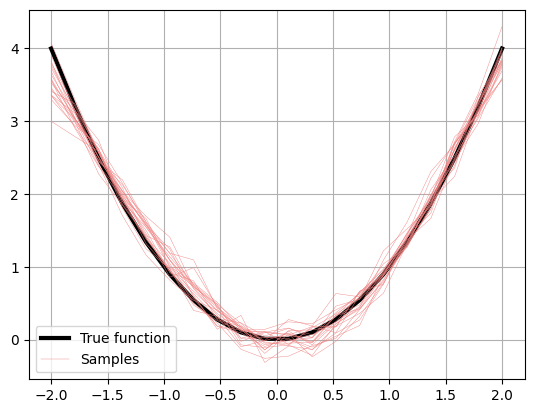

In [112]:
fig, ax = plt.subplots(1, 1)

ax.plot(space_draw, [real_operator(s) for s in space_draw], lw=3, color='k')
for i in range(n_test):
    ax.plot(space_draw, draws[i], lw=0.3, color='lightcoral')
ax.grid('both')
ax.legend(['True function', 'Samples'])

# Solve a nonlinear PDE with a numerical scheme

du/dt = a^2 - u^2, on [0, T] with initial condition u(0) = b <br>
The solution is <br>
u(t) = a * tanh(a * t + arctanh(b/a))

In [271]:
# numerical scheme for A :
# NUMERICAL SCHEME for A
nb_t = 41
b    = 1
a    = 2

mint, maxt = -2, 2
ts = np.linspace(mint, maxt, nb_t)

dt = (maxt - mint) /nb_t

In [272]:
space_draw

tensor([-2.0000, -1.7895, -1.5789, -1.3684, -1.1579, -0.9474, -0.7368, -0.5263,
        -0.3158, -0.1053,  0.1053,  0.3158,  0.5263,  0.7368,  0.9474,  1.1579,
         1.3684,  1.5789,  1.7895,  2.0000])

In [273]:
from scipy.integrate import solve_ivp
from scipy.interpolate import interp1d

solution_draws = {}

for i in range(n_test):
    oneSample  = draws[i]
    oneSample_interp   = interp1d(space_draw, oneSample)
    
    Bt         = lambda t, s: a**2 - oneSample_interp(t)**2
    sol        = solve_ivp(Bt, [mint, maxt], [b], t_eval=ts)
    B          = sol.y
    
    solution_draws[i] = B[0]

Bt         = lambda t, s: a**2 - real_operator(t)**2
sol        = solve_ivp(Bt, [mint, maxt], [b], t_eval=ts)
B          = sol.y

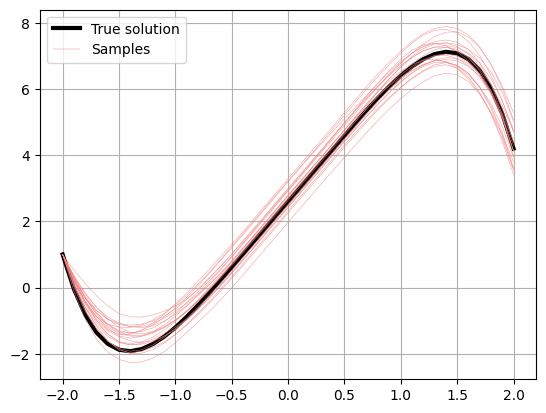

In [274]:
fig, ax = plt.subplots(1, 1)

ax.plot(ts, B[0], lw=3, color='k')
for i in range(n_test):
    ax.plot(ts, solution_draws[i], lw=0.3, color='lightcoral')
ax.grid('both')
ax.legend(['True solution', 'Samples'])

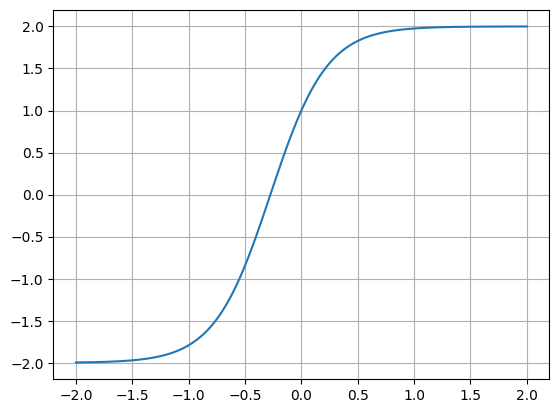

In [216]:
TrueSolution = [a * np.tanh(a * t + np.arctanh(b/a)) for t in ts]
plt.plot(ts, TrueSolution)
plt.grid()